In [3]:
import os
import re
import torch
import pandas as pd
import numpy as np
import keyword
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Leer dataset
df = pd.read_csv("pares.csv")
lista_de_todos_los_archivos = pd.concat([df["codigo_1"], df["codigo_2"]]).unique().tolist()

# === Inicializar CodeBERT ===
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='word')
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base", output_hidden_states=True)
model.eval()

def anonimizar_codigo(code):
    palabras_reservadas = set(keyword.kwlist)
    tokens = re.findall(r'\b[a-zA-Z_][a-zA-Z0-9_]*\b', code)

    usados = {}
    nuevo_codigo = code
    contador = 1

    for tok in tokens:
        # Evita palabras reservadas y ya usadas
        if tok not in usados and tok not in palabras_reservadas:
            usados[tok] = f"VAR_{contador}"
            contador += 1

    # Sustituye solo tokens enteros (usando límites de palabra)
    for original, nuevo in usados.items():
        nuevo_codigo = re.sub(rf'\b{re.escape(original)}\b', nuevo, nuevo_codigo)

    return nuevo_codigo

# Extraer función principal del archivo
def extraer_funcion_principal(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()
    funciones = re.findall(r"(def\s+[a-zA-Z_][a-zA-Z0-9_]*\(.*?\):(?:\n(?:\s{4}|\t).*)*)", code)
    return funciones[0] if funciones else code  # Si no hay funciones, usar todo

# Embedding con CodeBERT
def get_embedding(text, capa=4):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Lista de 13 tensores (incluye embedding inicial)
    capa_oculta = hidden_states[capa]      # Selecciona la capa que quieras

    # Tomamos el vector del token [CLS] de esa capa
    return capa_oculta[:, 0, :].squeeze().numpy()

def cargar_codigo(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

# Entrenar TF-IDF con todo el corpus primero (usa todos los códigos)
corpus = [cargar_codigo(path) for path in lista_de_todos_los_archivos]
vectorizer.fit(corpus)

# Función para vector TF-IDF
def get_tfidf_vector(text):
    return vectorizer.transform([text]).toarray()[0]

# === Extraer todas las funciones de un archivo ===
def extraer_todas_funciones(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()
    funciones = re.findall(r"(def\s+[a-zA-Z_][a-zA-Z0-9_]*\(.*?\):(?:\n(?:\s{4}|\t).*)*)", code)
    return funciones if funciones else [code]

# Función para vector combinado
def get_combined_vector(code1, code2):
    anon1 = anonimizar_codigo(code1)
    anon2 = anonimizar_codigo(code2)

    tfidf1 = get_tfidf_vector(anon1)
    tfidf2 = get_tfidf_vector(anon2)
    emb1 = get_embedding(anon1, capa=4)
    emb2 = get_embedding(anon2, capa=4)

    vector = np.concatenate([
        tfidf1, tfidf2, np.abs(tfidf1 - tfidf2),
        emb1, emb2, np.abs(emb1 - emb2)
    ])
    return vector


code1 = cargar_codigo("dataset/par-1-a-juego-puntuacion.py")
code2 = cargar_codigo("dataset/par-1-b-juego-puntuacion.py")
vector = get_combined_vector(code1, code2)

print(f"Vector combinado: {vector.shape}")


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Vector combinado: (430371,)


Funciones individuales (solo probar en 2 codigos)

In [4]:
import Levenshtein
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix)
def comparar_funciones_combinado(path1, path2):
    funciones_1 = extraer_todas_funciones(path1)
    funciones_2 = extraer_todas_funciones(path2)

    print(f"🔍 {len(funciones_1)} funciones en {path1}")
    print(f"🔍 {len(funciones_2)} funciones en {path2}")

    # Anonimizar funciones
    funcs_anon_1 = [anonimizar_codigo(f) for f in funciones_1]
    funcs_anon_2 = [anonimizar_codigo(f) for f in funciones_2]

    # TF-IDF
    tfidf_1 = [get_tfidf_vector(f) for f in funcs_anon_1]
    tfidf_2 = [get_tfidf_vector(f) for f in funcs_anon_2]

    # CodeBERT
    emb_1 = [get_embedding(f, capa=1) for f in funcs_anon_1]
    emb_2 = [get_embedding(f, capa=1) for f in funcs_anon_2]

    similitudes = []
    for i, (e1, t1) in enumerate(zip(emb_1, tfidf_1)):
        fila = []
        for j, (e2, t2) in enumerate(zip(emb_2, tfidf_2)):
            sim_bert = cosine_similarity([e1], [e2])[0][0]
            sim_tfidf = cosine_similarity([t1], [t2])[0][0]
            sim_combinada = 0.3 * sim_bert + 0.7 * sim_tfidf
            fila.append(sim_combinada)
            print(f"Sim f{i} vs f{j}: TF-IDF={sim_tfidf:.4f}, CodeBERT={sim_bert:.4f}, Combinada={sim_combinada:.4f}")
        similitudes.append(fila)

    return np.array(similitudes)

def features_por_par(path1, path2):
    if not os.path.exists(path1) or not os.path.exists(path2):
        return None

    funcs1 = extraer_todas_funciones(path1)
    funcs2 = extraer_todas_funciones(path2)

    # Validación rápida: sin funciones útiles
    if not funcs1 or not funcs2:
        return None

    # Anonimizamos funciones
    funcs1_anon = [anonimizar_codigo(f) for f in funcs1 if len(f.strip()) > 5]
    funcs2_anon = [anonimizar_codigo(f) for f in funcs2 if len(f.strip()) > 5]

    if not funcs1_anon or not funcs2_anon:
        return None

    # Embeddings con CodeBERT (token [CLS] de capa alta)
    emb1 = [get_embedding(f, capa=12) for f in funcs1_anon]
    emb2 = [get_embedding(f, capa=12) for f in funcs2_anon]

    if not emb1 or not emb2:
        return None

    # Cosine similarity máxima entre funciones (CodeBERT)
    sim_cos_max = max(np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)) for e1 in emb1 for e2 in emb2)

    maximos_1_a_2 = [
        max(np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)) for e2 in emb2)
        for e1 in emb1
    ]
    maximos_2_a_1 = [
        max(np.dot(e2, e1) / (np.linalg.norm(e2) * np.linalg.norm(e1)) for e1 in emb1)
        for e2 in emb2
    ]
    sim_cos_avg = sum(maximos_1_a_2 + maximos_2_a_1) / (len(maximos_1_a_2) + len(maximos_2_a_1))

    # TF-IDF entre código completo anonimizado
    all_code1 = " ".join(funcs1_anon)
    all_code2 = " ".join(funcs2_anon)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([all_code1, all_code2])
    sim_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    # Similitud combinada
    sim_comb_avg = 0.3 * sim_cos_avg + 0.7 * sim_tfidf
    sim_comb_max = 0.3 * sim_cos_max + 0.7 * sim_tfidf

    # Levenshtein
    lev_sim = 1 - Levenshtein.distance(all_code1, all_code2) / max(len(all_code1), len(all_code2))

    # Jaccard
    tokens1 = set(all_code1.split())
    tokens2 = set(all_code2.split())
    union = tokens1.union(tokens2)
    sim_jaccard = len(tokens1.intersection(tokens2)) / len(union) if union else 0.0

    # Longitudes
    len_total_1 = len(all_code1.split())
    len_total_2 = len(all_code2.split())
    len_diff = abs(len_total_1 - len_total_2)

    return [
        sim_comb_avg, sim_comb_max,  # combinadas
        sim_cos_avg, sim_cos_max,    # solo CodeBERT
        sim_tfidf,
        sim_jaccard,
        lev_sim,
        len_total_1, len_total_2, len_diff
    ]

if __name__ == "__main__":
    archivo_a = "dataset/par-9-d-behavior-propagation.py"
    archivo_b = "dataset/par-9-a-behavior-propagation.py"
    
    # Entrenar TF-IDF antes de comparar
    df = pd.read_csv("pares.csv")
    lista_archivos = pd.concat([df["codigo_1"], df["codigo_2"]]).unique().tolist()
    corpus = [cargar_codigo(p) for p in lista_archivos]
    vectorizer.fit(corpus)

    matriz = comparar_funciones_combinado(archivo_a, archivo_b)
    
    arr_feat = features_por_par(archivo_a,archivo_b)
    
    print(arr_feat)
    print("\n🧾 Matriz de similitud combinada:")
    print(np.round(matriz, 4))



NameError: name 'pd' is not defined

Solo ecleudiana

Pares válidos: 1278
Distribución: Counter({3: 427, 2: 427, 1: 424})
              precision    recall  f1-score   support

           1       0.54      0.88      0.67       128
           2       0.68      0.36      0.47       128
           3       0.79      0.66      0.72       128

    accuracy                           0.63       384
   macro avg       0.67      0.63      0.62       384
weighted avg       0.67      0.63      0.62       384



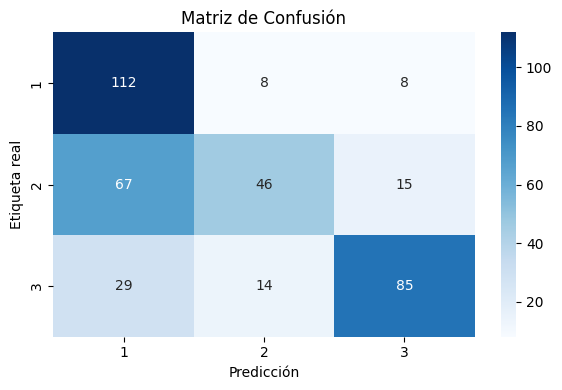

In [10]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,confusion_matrix)
from collections import Counter
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

# Asegúrate de tener definidas estas funciones (ya las tienes):
# - anonimizar_codigo()
# - extraer_todas_funciones()
# - obtener_embedding()

def features_por_par(path1, path2, anonimizar=True):
    if not os.path.exists(path1) or not os.path.exists(path2):
        return None

    funcs1 = extraer_todas_funciones(path1)
    funcs2 = extraer_todas_funciones(path2)

    funcs1 = [anonimizar_codigo(f) for f in funcs1]
    funcs2 = [anonimizar_codigo(f) for f in funcs2]

    # Embeddings con CodeBERT (por función)
    emb1 = [get_embedding(f, capa=4) for f in funcs1]
    emb2 = [get_embedding(f, capa=4) for f in funcs2]

    if not emb1 or not emb2:
        return None

    # Distancias Euclidianas negativas entre todas las combinaciones
    distancias = [-euclidean(e1, e2) for e1 in emb1 for e2 in emb2]
    
    max_sim = max(distancias)
    avg_sim = np.mean(distancias)
    count_95 = sum(1 for s in distancias if s > -0.05)
    count_90 = sum(1 for s in distancias if s > -0.1)

    # TF-IDF similarity (cosine) entre todo el código de cada archivo
    all_code1 = " ".join(funcs1)
    all_code2 = " ".join(funcs2)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([all_code1, all_code2])
    sim_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    return [max_sim, avg_sim, count_95, count_90, len(emb1), len(emb2), sim_tfidf]


#Entrenar modelo

csv_path = "pares.csv"

df = pd.read_csv(csv_path)
X, y = [], []

for _, row in df.iterrows():
    path1, path2, label = row["codigo_1"], row["codigo_2"], row["tipo_plagio"]
    feats = features_por_par(path1, path2)
    if label != 4:
        if feats is not None:
            X.append(feats)
            y.append(label)

print(f"Pares válidos: {len(X)}")
print("Distribución:", Counter(y))

if len(set(y)) > 1:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    matriz = confusion_matrix(y_test, y_pred)
    labels = sorted(list(set(y)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("⚠️ Solo hay una clase en el dataset. No se puede entrenar.")

Ecleudiana y jaccard

Pares válidos: 1278
Distribución: Counter({3: 427, 2: 427, 1: 424})
              precision    recall  f1-score   support

           1       0.61      0.84      0.71       128
           2       0.69      0.53      0.60       128
           3       0.84      0.71      0.77       128

    accuracy                           0.70       384
   macro avg       0.71      0.70      0.69       384
weighted avg       0.71      0.70      0.69       384



c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


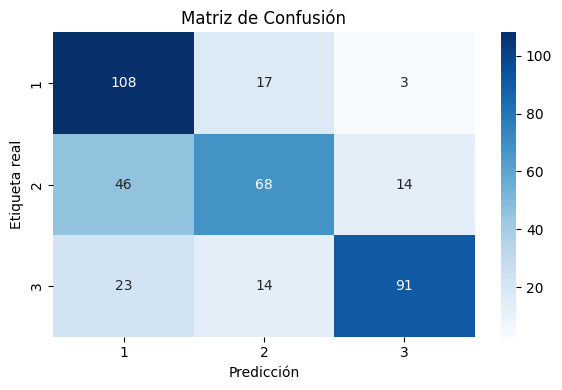

In [12]:
# Asegúrate de tener definidas estas funciones (ya las tienes):
# - anonimizar_codigo()
# - extraer_todas_funciones()
# - obtener_embedding()
import Levenshtein

def features_por_par(path1, path2):
    if not os.path.exists(path1) or not os.path.exists(path2):
        return None

    funcs1 = extraer_todas_funciones(path1)
    funcs2 = extraer_todas_funciones(path2)

    # Anonimizamos funciones
    funcs1_anon = [anonimizar_codigo(f) for f in funcs1]
    funcs2_anon = [anonimizar_codigo(f) for f in funcs2]

    # Embeddings con CodeBERT (por función)
    emb1 = [get_embedding(f, capa=4) for f in funcs1_anon]
    emb2 = [get_embedding(f, capa=4) for f in funcs2_anon]

    if not emb1 or not emb2:
        return None

    # Distancias Euclidianas negativas entre todas las combinaciones
    distancias = [-euclidean(e1, e2) for e1 in emb1 for e2 in emb2]

    max_sim = max(distancias)
    min_sim = min(distancias)
    avg_sim = np.mean(distancias)
    count_95 = sum(1 for s in distancias if s > -0.05)
    count_90 = sum(1 for s in distancias if s > -0.1)
    
    total_pares = len(emb1) * len(emb2)
    prop_95 = count_95 / total_pares if total_pares > 0 else 0
    prop_90 = count_90 / total_pares if total_pares > 0 else 0
    
    # TF-IDF similarity (cosine) entre todo el código de cada archivo
    all_code1 = " ".join(funcs1_anon)
    all_code2 = " ".join(funcs2_anon)
    
    lev_sim = 1 - Levenshtein.distance(all_code1, all_code2) / max(len(all_code1), len(all_code2))
    len_total_1 = len(all_code1.split())
    len_total_2 = len(all_code2.split())
    len_diff = abs(len_total_1 - len_total_2)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([all_code1, all_code2])
    sim_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    # Similitud de Jaccard (a nivel de tokens)
    tokens1 = set(all_code1.split())
    tokens2 = set(all_code2.split())

    inter = tokens1.intersection(tokens2)
    union = tokens1.union(tokens2)
    sim_jaccard = len(inter) / len(union) if union else 0.0

    return [max_sim, avg_sim, min_sim, count_95, count_90, prop_95, prop_90, 
    len(emb1), len(emb2), sim_tfidf, sim_jaccard, lev_sim, len_total_1, len_total_2, len_diff]


csv_path = "pares.csv"

df = pd.read_csv(csv_path)
X, y = [], []

for _, row in df.iterrows():
    path1, path2, label = row["codigo_1"], row["codigo_2"], row["tipo_plagio"]
    feats = features_por_par(path1, path2)
    if label != 4:
        if feats is not None:
            X.append(feats)
            y.append(label)

print(f"Pares válidos: {len(X)}")
print("Distribución:", Counter(y))

if len(set(y)) > 1:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    matriz = confusion_matrix(y_test, y_pred)
    labels = sorted(list(set(y)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("⚠️ Solo hay una clase en el dataset. No se puede entrenar.")

Coseno y jaccard

Pares válidos: 1278
Distribución: Counter({3: 427, 2: 427, 1: 424})


c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           1       0.60      0.88      0.72       128
           2       0.70      0.48      0.57       128
           3       0.83      0.70      0.76       128

    accuracy                           0.69       384
   macro avg       0.71      0.69      0.68       384
weighted avg       0.71      0.69      0.68       384



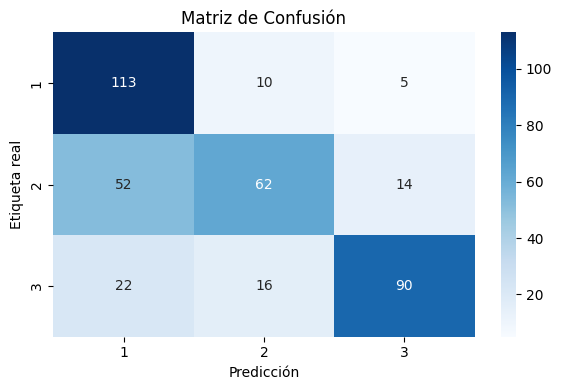

In [13]:
import pandas as pd
import numpy as np
import os
import Levenshtein
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from scipy.spatial.distance import euclidean


# Asegúrate de tener definidas estas funciones (ya las tienes):
# - anonimizar_codigo()
# - extraer_todas_funciones()
# - obtener_embedding()

def features_por_par(path1, path2):
    if not os.path.exists(path1) or not os.path.exists(path2):
        return None

    funcs1 = extraer_todas_funciones(path1)
    funcs2 = extraer_todas_funciones(path2)

    # Validación rápida: sin funciones útiles
    if not funcs1 or not funcs2:
        return None

    # Anonimizamos funciones
    funcs1_anon = [anonimizar_codigo(f) for f in funcs1 if len(f.strip()) > 5]
    funcs2_anon = [anonimizar_codigo(f) for f in funcs2 if len(f.strip()) > 5]

    if not funcs1_anon or not funcs2_anon:
        return None

    # Embeddings con CodeBERT (token [CLS] de capa alta)
    emb1 = [get_embedding(f, capa=12) for f in funcs1_anon]
    emb2 = [get_embedding(f, capa=12) for f in funcs2_anon]

    if not emb1 or not emb2:
        return None

    # Cosine similarity máxima entre funciones (CodeBERT)
    sim_cos_max = max(np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)) for e1 in emb1 for e2 in emb2)

    maximos_1_a_2 = [
        max(np.dot(e1, e2) / (np.linalg.norm(e1) * np.linalg.norm(e2)) for e2 in emb2)
        for e1 in emb1
    ]
    maximos_2_a_1 = [
        max(np.dot(e2, e1) / (np.linalg.norm(e2) * np.linalg.norm(e1)) for e1 in emb1)
        for e2 in emb2
    ]
    sim_cos_avg = sum(maximos_1_a_2 + maximos_2_a_1) / (len(maximos_1_a_2) + len(maximos_2_a_1))

    # TF-IDF entre código completo anonimizado
    all_code1 = " ".join(funcs1_anon)
    all_code2 = " ".join(funcs2_anon)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([all_code1, all_code2])
    sim_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]

    # Similitud combinada
    sim_comb_avg = 0.3 * sim_cos_avg + 0.7 * sim_tfidf
    sim_comb_max = 0.3 * sim_cos_max + 0.7 * sim_tfidf

    # Levenshtein
    lev_sim = 1 - Levenshtein.distance(all_code1, all_code2) / max(len(all_code1), len(all_code2))

    # Jaccard
    tokens1 = set(all_code1.split())
    tokens2 = set(all_code2.split())
    union = tokens1.union(tokens2)
    sim_jaccard = len(tokens1.intersection(tokens2)) / len(union) if union else 0.0

    # Longitudes
    len_total_1 = len(all_code1.split())
    len_total_2 = len(all_code2.split())
    len_diff = abs(len_total_1 - len_total_2)

    return [
        sim_comb_avg, sim_comb_max,  # combinadas
        sim_cos_avg, sim_cos_max,    # solo CodeBERT
        sim_tfidf,
        sim_jaccard,
        lev_sim,
        len_total_1, len_total_2, len_diff
    ]


csv_path = "pares.csv"

df = pd.read_csv(csv_path)
X, y = [], []

for _, row in df.iterrows():
    path1, path2, label = row["codigo_1"], row["codigo_2"], row["tipo_plagio"]
    feats = features_por_par(path1, path2)
    if label != 4:
        if feats is not None:
            X.append(feats)
            y.append(label)

print(f"Pares válidos: {len(X)}")
print("Distribución:", Counter(y))

if len(set(y)) > 1:
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    matriz = confusion_matrix(y_test, y_pred)
    labels = sorted(list(set(y)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta real')
    plt.tight_layout()
    plt.show()
    plt.close()
else:
    print("⚠️ Solo hay una clase en el dataset. No se puede entrenar.")